# Oakland Race and Equity Main 

This where consolidated cleaning and data exploration for the project will take place.

## Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

## Import Data

The data is the ACS (American Community Survey) PUMS (Public Use Microdata) provided by the US census website.
- The data comes as two periods, a 1 year period (2019 latest) and a 5 year (2015-2019 latest)
- Each period has two datasets, person (denotes individuals) and household (denotes households)

2019, 1 year datasets can be found at these links:<br>
<b>Person</b><br>
https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_pca.zip<br>
<b>Household</b><br>
https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_hca.zip

For readability, we renamed 1 year csv files to to `2019pCA1.csv` and `2019hCA1.csv` respectively.

In [2]:
pca191 = pd.read_csv("./Data/2019pCA1.csv")
hca191 = pd.read_csv("./Data/2019hCA1.csv")

FileNotFoundError: [Errno 2] File b'./Data/2019pCA1.csv' does not exist: b'./Data/2019pCA1.csv'

### Minor data exploration

In [ ]:
pca191.head()

In [ ]:
hca191.head()

In [ ]:
print("California House data dimensions: " + str(hca191.shape))
print("California Person data dimensions: " + str(pca191.shape))

## Cleaning

### Filtering Relevant Columns

There are 288 columns in the population dataset, and only about 20 indicators we need to calculate using this data, meaning most are useless for the purpose of this project. We will cut out the columns that are not used in indicator calculations and are not useful to us in analysis.

In [ ]:
pca191 = pca191.loc[:, ["SERIALNO", "SPORDER", "PUMA", "PWGTP", "AGEP", "CIT", "COW", "ENG", "FER", "JWMNP"
               , "JWTRNS", "MAR", "MIL", "SCH", "SCHL", "RELSHIPP", "SEX", "PAP", "INTP", "SSIP", "SSP", "WAGP"
               , "OIP", "RETP", "SEMP", "PERNP", "PINCP", "WKL", "DIS", "ESR", "HICOV", "HISP"
               , "PAOC", "POVPIP", "RAC1P", "RACASN", "RACBLK", "RACWHT", "RACSOR", "SCIENGP", "WKWN", "WKHP"
               , "SOCP"]].copy()

In [ ]:
hca191 = hca191.loc[:, ["SERIALNO", "PUMA", "NP", "ACCESS", "ACR", "BATH", "FS", "FFSP","ELEP", "FULP", "GASP", "HISPEED"
              , "LAPTOP", "RNTP", "RWATPR", "TEN", "VALP", "VEH", "WATP", "HINCP", "HUPAC", "KIT", "PLM"
              , "GRPIP", "RMSP"]].copy()

In [ ]:
print("New P dataset dimensions: " + str(pca191.shape))

In [ ]:
print("New H dataset dimensions: " + str(hca191.shape))

### Filtering PUMA codes

We don't want to use all of California's data for the main project, just Oakland data. ~However, we will make a separate dataset for the sorrounding areas for plotting later.~ (Still unsure of wether I'll do this)

Oakland uses PUMA codes codes 102-105, so we take out data not in these areas.

We will make a copy of the orignal data to make the subsets, to avoid a `SettingwithCopyWarning` error and we may use the entire dataset later, so we don't want to overwrite it.

In [ ]:
pca191_Ok = pca191.loc[(pca191["PUMA"] > 101) & (pca191["PUMA"] <= 105)].copy()
hca191_Ok = hca191.loc[(hca191["PUMA"] > 101) & (hca191["PUMA"] <= 105)].copy()

In [ ]:
print("Oakland House data dimensions: " + str(pca191_Ok.shape))
print("Oakland Population data dimensions: " + str(hca191_Ok.shape))

### Making a 'RACE' column

For the purpose of this report, we are only examining 5 races
- African American
- Asian
- Latino
- White
- Other

The races are denoted by the `RAC1P` column in the population dataset. They're coded as follows:

- African American - 2
- Asian - 6
- White - 1
- Other - 3, 4, 5, 7, 8, 9

Latinos can be any race, so the `HISP` column denotes people who identify as Latino instead of `RAC1P`. Non-Latinos must have a value of <i>1</i> in the `HISP` column to not be counted as hispanic. Otherwise, if `HISP` is any value other than <i>1</i>, the person is counted as Latino regardless of race.

In [ ]:
pca191_Ok.loc[(pca191_Ok.RAC1P == 1) & (pca191_Ok.HISP == 1), "RACE"] = "White"
pca191_Ok.loc[(pca191_Ok.RAC1P == 2) & (pca191_Ok.HISP == 1), "RACE"] = "African American"
pca191_Ok.loc[(pca191_Ok.RAC1P == 6) & (pca191_Ok.HISP == 1), "RACE"] = "Asian"
pca191_Ok.loc[(pca191_Ok.RAC1P.isin([3, 4, 5, 7, 8, 9])) & (pca191_Ok.HISP == 1), "RACE"] = "Other"
pca191_Ok.loc[pca191_Ok.HISP != 1, "RACE"] = "Latino"

We will check the logic with a random sample.

In [ ]:
pca191_Ok.sample(n=5, random_state=8)[["RAC1P", "HISP", "RACE"]]

The races have been correctly assigned.

### Merging Household data

We will merge household data with a left join, with the person dataset being the left table.

In [ ]:
pca191_Ok = pca191_Ok.merge(hca191_Ok, how = 'left', on = 'SERIALNO')

In [ ]:
pca191_Ok.tail(5)

In [ ]:
pca191_Ok.shape

We kept the same number of rows in the persons data and added the household columns appropriately.

### Examine NAs

We'll run a loop to tell me which columns have NA data.

In [ ]:
message = "Missing values in the following columns: \n"
for column in pca191_Ok.columns:
    if pca191_Ok[column].isnull().values.any():
        message += column + ", "
print(message)

The PUMS dataset classifies NAs as data that is not available because the current user doesn't qualify for the column.

For example, users under 16 have NAs in the `WAGP` column because they can't legally work. Likewise users who haven't gone to college have and NA in the `SCIENGP` column, which denotes a STEM degree.

Because the NA's vary so much in the data, <b>we will not get rid of any NAs until we do statistical analysis and cannot fill them with a <i>0</i> value or the mean as the NAs represent data that cannot exist.</b>

### Duplicate data

The final step of the data cleaning will be to explode the data. Since the PUMS dataset is weighted survey data, each row represents a group of people determined by the `PWGTP` column. For example, the first row in the dataset has a `PWGTP` value of 13, meaning that row accounts for 13 people. 

Because we will be performing statistical and machine learning analysis on the data, we need to take the weights into consideration. A simple way to do this is to duplicate the rows based on the weight column value. For example, going back to the first row, since the `PWGTP` value is 13, we will duplicate the row 13 times. 

In [ ]:
pca191_Ok = pca191_Ok.reindex(pca191_Ok.index.repeat(pca191_Ok.PWGTP)).reset_index(drop=True).drop(['PWGTP'], axis=1).rename(columns={"PUMA_x": "PUMA"}).copy()

In [ ]:
pca191_Ok.head(5)

In [ ]:
print("Dimensions for the final person dataset: " + str(pca191_Ok.shape))
print("New DataFrame size: " + str(int(pca191_Ok.memory_usage(index=True).sum()/1000000)) + " MB")

### Cleaning 2016 Data

We will proces the 2016 PUMS data in the same way as the 2019 to produce the same type of cleaned file. This will help us validate our results for 2019, by checking that we are calculating the indicators correctly with 2016 data, as we have the results from the 2016 project.


2016, 1 year datasets can be found at these links:<br>
<b>Person (csv_pca.zip)</b><br>
https://www2.census.gov/programs-surveys/acs/data/pums/2016/1-Year/<br>
<b>Household (csv_hca.zip)</b><br>
https://www2.census.gov/programs-surveys/acs/data/pums/2016/1-Year/

In [ ]:
pca161 = pd.read_csv("./Data/2016pCA1.csv")
hca161 = pd.read_csv("./Data/2016hCA1.csv")
pca161 = pca161.loc[:, ["SERIALNO", "SPORDER", "PUMA", "PWGTP", "AGEP", "CIT", "COW", "ENG", "FER", "JWMNP"
               , "MAR", "MIL", "SCH", "SCHL", "SEX", "PAP", "INTP", "SSIP", "SSP", "WAGP"
               , "OIP", "RETP", "SEMP", "PERNP", "PINCP", "WKL", "DIS", "ESR", "HICOV", "HISP"
               , "PAOC", "POVPIP", "RAC1P", "RACASN", "RACBLK", "RACWHT", "RACSOR", "SCIENGP", "WKHP"
               , "SOCP", "RELP"]].copy()
hca161 = hca161.loc[:, ["SERIALNO", "PUMA", "NP", "ACCESS", "ACR", "BATH", "FS", "ELEP", "FULP", "GASP", "HISPEED"
              , "LAPTOP", "RNTP", "RWATPR", "TEN", "VALP", "VEH", "WATP", "HINCP", "HUPAC", "KIT", "PLM"
              , "GRPIP", "RMSP"]].copy()
pca161_Ok = pca161.loc[(pca161["PUMA"] > 101) & (pca161["PUMA"] <= 105)].copy()
hca161_Ok = hca161.loc[(hca161["PUMA"] > 101) & (hca161["PUMA"] <= 105)].copy()
pca161_Ok.loc[(pca161_Ok.RAC1P == 1) & (pca161_Ok.HISP == 1), "RACE"] = "White"
pca161_Ok.loc[(pca161_Ok.RAC1P == 2) & (pca161_Ok.HISP == 1), "RACE"] = "African American"
pca161_Ok.loc[(pca161_Ok.RAC1P == 6) & (pca161_Ok.HISP == 1), "RACE"] = "Asian"
pca161_Ok.loc[(pca161_Ok.RAC1P.isin([3, 4, 5, 7, 8, 9])) & (pca161_Ok.HISP == 1), "RACE"] = "Other"
pca161_Ok.loc[pca161_Ok.HISP != 1, "RACE"] = "Latino"
pca161_Ok = pca161_Ok.merge(hca161_Ok, how = 'left', on = 'SERIALNO').copy()
pca161_Ok = pca161_Ok.reindex(pca161_Ok.index.repeat(pca161_Ok.PWGTP)).reset_index(drop=True).drop(['PWGTP'], axis=1).rename(columns={"PUMA_x": "PUMA"}).copy()

In [ ]:
print("Dimensions for the final person dataset: " + str(pca161_Ok.shape))
print("New DataFrame size: " + str(int(pca161_Ok.memory_usage(index=True).sum()/1000000)) + " MB")

### Test Business Ownership

In [ ]:
bo = pca161_Ok.loc[pca161_Ok["COW"] == 7, ["RACE"]].groupby("RACE")['RACE'].count()

In [ ]:
ep = pca161_Ok.loc[(pca161_Ok["COW"] != 9) & (pca161_Ok["COW"].notna()), ["RACE"]].groupby("RACE")['RACE'].count()

In [ ]:
bo/ep * 100

### Home Ownership

In [ ]:
dh = pca161_Ok.loc[(pca161_Ok.RELP == 0) & ((pca161_Ok.TEN == 2) | (pca161_Ok.TEN == 1)), ["RACE"]].groupby("RACE")['RACE'].count()

In [ ]:
da = pca161_Ok.loc[pca161_Ok.RELP == 0, ["RACE"]].groupby("RACE")['RACE'].count()

In [ ]:
1 - dh/da

### Energy Cost Burden

In [ ]:
pca161_Ok_EC = pca161_Ok.loc[:, ["RELP", "ELEP", "FULP", "GASP", "HINCP", "RACE"]]
pca161_Ok_EC = pca161_Ok_EC.loc[pca161_Ok_EC.RELP == 0]
pca161_Ok_EC.loc[pca161_Ok_EC["ELEP"] == 2, "ELEP"] = 0
pca161_Ok_EC.loc[(pca161_Ok_EC["FULP"] == 1) | (pca161_Ok_EC["FULP"] ==  2), "FULP"] = 0
pca161_Ok_EC.loc[(pca161_Ok_EC["GASP"] == 2) | (pca161_Ok_EC["GASP"] == 3), "GASP"] = 0
pca161_Ok_EC = pca161_Ok_EC.loc[(pca161_Ok_EC["ELEP"] != 1) & (pca161_Ok_EC["GASP"] != 1)]
pca161_Ok_EC = pca161_Ok_EC.loc[pca161_Ok_EC["HINCP"] > 0]

In [ ]:
energy = ((pca161_Ok_EC.ELEP * 12) + (pca161_Ok_EC.GASP * 12) + pca161_Ok_EC.FULP)/pca161_Ok_EC.HINCP
pca161_Ok_EC["ENERGY"] = energy

In [ ]:
pca161_Ok_EC[["RACE", "ENERGY"]].groupby("RACE").median()

### High Speed Internet

In [ ]:
hs = pca161_Ok.loc[(pca161_Ok.RELP == 0) & (pca161_Ok.HISPEED == 1)].groupby("RACE")["RACE"].count()

In [ ]:
ss = pca161_Ok.loc[pca161_Ok.RELP == 0, ["RACE"]].groupby("RACE")['RACE'].count()

In [ ]:
1 -(hs/ss)

## Visualization

ESR != NA, 6
Sex = 1.male 2. female

In [ ]:
dfC1 = pca191_Ok.loc[(pca191_Ok["ESR"] != 6) & (pca191_Ok["ESR"].notna()), ["RACE", "SEX", "PINCP"]]

In [ ]:
print(dfC1.shape)
dfC1.head()

In [ ]:
#test.columns = test.columns.droplevel(0)

In [ ]:
chartData =  dfC1.groupby(["RACE", "SEX"], as_index=False).mean()
chartData

In [ ]:
#Adjust for inflation

In [ ]:
dfC2 = pca161_Ok.loc[(pca161_Ok["ESR"] != 6) & (pca161_Ok["ESR"].notna()), ["RACE", "SEX", "PINCP"]]

In [ ]:
chartData2 =  dfC2.groupby(["RACE", "SEX"], as_index=False).mean()
chartData2

In [ ]:
fig1 = go.Figure(
    data = [
        go.Bar(
            name="Male 2016",
            x=chartData2.RACE.unique(),
            y=chartData2.loc[chartData2["SEX"] ==1, "PINCP"],
            offsetgroup=0,
        ),
        go.Bar(
            name="Female 2016",
            x=chartData2.RACE.unique(),
            y=chartData2.loc[chartData2["SEX"] ==2, "PINCP"],
            offsetgroup=0,
        ),
                go.Bar(
            name="Male 2019",
            x=chartData.RACE.unique(),
            y=chartData.loc[chartData["SEX"] ==1, "PINCP"],
            offsetgroup=1,
        ),
        go.Bar(
            name="Female 2019",
            x=chartData.RACE.unique(),
            y=chartData.loc[chartData["SEX"] ==2, "PINCP"],
            offsetgroup=1,
            #base=grouped_single.loc[grouped_single["Sex"] ==1, "Wages"],
        ),
    ],
    layout=go.Layout(
        #barmode='stack',
        title="Income vs Ethnicty and Gender (2016 vs 2018)",
        yaxis_title="Average Yearly Income",
        xaxis_title="Ethnicity"
    )
)

In [ ]:
fig1.show()

## Logistic Regression

I'll start by taking a look at the features in our cleaned dataset.

### Data Exploration and Cleaning

In [531]:
pca191_Ok.columns

Index(['SERIALNO', 'SPORDER', 'PUMA', 'AGEP', 'CIT', 'COW', 'ENG', 'FER',
       'JWMNP', 'JWTRNS', 'MAR', 'MIL', 'SCH', 'SCHL', 'RELSHIPP', 'SEX',
       'PAP', 'INTP', 'SSIP', 'SSP', 'WAGP', 'OIP', 'RETP', 'SEMP', 'PERNP',
       'PINCP', 'WKL', 'DIS', 'ESR', 'HICOV', 'HISP', 'PAOC', 'POVPIP',
       'RAC1P', 'RACASN', 'RACBLK', 'RACWHT', 'RACSOR', 'SCIENGP', 'WKWN',
       'WKHP', 'SOCP', 'RACE', 'PUMA_y', 'NP', 'ACCESS', 'ACR', 'BATH', 'FS',
       'FFSP', 'ELEP', 'FULP', 'GASP', 'HISPEED', 'LAPTOP', 'RNTP', 'RWATPR',
       'TEN', 'VALP', 'VEH', 'WATP', 'HINCP', 'HUPAC', 'KIT', 'PLM', 'GRPIP',
       'RMSP'],
      dtype='object')

#### Choosing dependent variable

The dependent variable is if an individual needs government aid.

An individual who needs government aid, is anyone that is currently on food stamps, receiving financial aid, or receiving medic-aid. The features describing an individal are noted below.
- FS - Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency
- FFSP - Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency allocation flag
- HINS4 - Medicaid, Medical Assistance, or any kind of government-assistance plan
- PAP - Public assistance income past 12 months

#### Choosing initial predictors

The following features are what I think will explain the DV the best.

- PUMA - Area code (Nominal)
- RELSHIPP - Indicator of a 'reference person'
- AGEP - Age of individual (Ratio)
- ESR - Employment status (Nominal)
- ENG - Ability to speak English (Ordinal)
- FER - Gave birth to a child in the past 12 months (Binary)
- JWMNP - Travel Time to Work (Ratio)
- JWTRNS - Means of transportation to work (Nominal)
- MIL - Military Service (Nominal)
- SCHL - Educational Attainment (Ordinal)
- SEX - Sex of Individual (Binary)
- DIS - Disability Indicator (Binary)
- HICOV - Health Insurace Indicatory (Binary)
- WKHP - Usual hours worked per week (Ratio)
- NP - Number of people in household (Interval)
- ACCESS - Access to internet (Binary)
- ELEP - Monthly Electricity Cost (Interval)
- FULP - Yearly Fuel cost (Other than Gas and Electricity) (Interval)
- GASP - Monthly Gas cost (Interval)
- RNTP - Monthly rent (Interval)
- WATP - Yearly water cost (Interval)
- PERNP - Total Person's Earnings (Ratio)

In total, there are:
- 11 Categorical Features
- 10 Numerical Features

We'll make a dataframe for the predictors and DVs.

In [536]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()

Make new calculated column for dependent variable.

In [537]:
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)

In [538]:
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

I want to only examine individuals who are in the labort force, so I will filter out those who aren't (retired, not looking for work, etc.)

In [539]:
df= df.loc[df.ESR != 6].copy()

Lastly, for the purpose of this study, we only want to examine 'Reference Persons', who are the head of households, as I have the most complete data on them

In [540]:
df = df.loc[df.RELSHIPP == 20].copy()

In [541]:
print(df.shape)
df.head()

(170752, 21)


,PUMA,RELSHIPP,AGEP,ESR,FER,JWMNP,JWTRNS,MIL,SCHL,SEX,DIS,HICOV,WKHP,ACCESS,ELEP,FULP,GASP,RNTP,WATP,PERNP,ASSISTANCE
6848,104,20,39,1.0,2.0,45.0,1.0,4.0,24.0,2,2,1,40.0,1.0,90.0,NaN,NaN,NaN,1600.0,180000.0,0.0
6849,104,20,39,1.0,2.0,45.0,1.0,4.0,24.0,2,2,1,40.0,1.0,90.0,NaN,NaN,NaN,1600.0,180000.0,0.0
6850,104,20,39,1.0,2.0,45.0,1.0,4.0,24.0,2,2,1,40.0,1.0,90.0,NaN,NaN,NaN,1600.0,180000.0,0.0
6851,104,20,39,1.0,2.0,45.0,1.0,4.0,24.0,2,2,1,40.0,1.0,90.0,NaN,NaN,NaN,1600.0,180000.0,0.0
6852,104,20,39,1.0,2.0,45.0,1.0,4.0,24.0,2,2,1,40.0,1.0,90.0,NaN,NaN,NaN,1600.0,180000.0,0.0


### NA Analysis

I'll print out the features that have NAs. to start cleaning them.

In [542]:
for feature in df.columns.values:
    if df[str(feature)].isna().sum() == 0:
        pass
    else:
        print(str(feature) + " NA count: " + str(df[str(feature)].isna().sum())) 


FER NA count: 118215
JWMNP NA count: 20843
JWTRNS NA count: 9609
WKHP NA count: 1920
ELEP NA count: 8764
FULP NA count: 167894
GASP NA count: 104461
RNTP NA count: 71031
WATP NA count: 74205


A null in `FER` denote a male, a child under 15, or an adult above 50. Nulls will be recoded to 2 (no).<br>
A null in `JWMNP` denotes travel time. Nulls will be recoded to 0 (No travel time).<br>
A null in `JWTRNS` denotes someone who does not travel to work, is under 16, is not in the labor force, is unemployed or is not currently at work. Because of the high number of nulls and the lack of an appropriate recoding method, this column will be removed.<br>
A null in `WKHP` denotes people under 16 or who haven't worked. Nulls will be recoded as zero.<br>
A null in `ELEP` denotes no electricity payment because of many different reasons. Nulls will be removed from dataset.<br>
A null in `FULP` denotes no Fuel payment for a variety of reasons. Because most inputs are null, feature will be removed.<br>
A null in `GASP` denotes no Gas payment for a variety of reasons. Because over half of inputs are null, feature will be removed.<br>
A null in `RNTP` denotes no rent payment for a variety of reasons. Null will be recoded to 0.<br>
A null in `WATP` denotes no rent payment for a variety of reasons. Null will be recoded to 0.

In [543]:
df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df = df.loc[df['ELEP'].notna()]
df = df.drop(columns=['JWTRNS', 'FULP', 'GASP']).copy()

Sanity Check for NA values

In [544]:
for feature in df.columns.values:
    if df[str(feature)].isna().sum() == 0:
        pass
    else:
        print(str(feature) + " NA count: " + str(df[str(feature)].isna().sum())) 

No more NAs!

In [545]:
print(df.shape)
df.head()

(161988, 18)


,PUMA,RELSHIPP,AGEP,ESR,FER,JWMNP,MIL,SCHL,SEX,DIS,HICOV,WKHP,ACCESS,ELEP,RNTP,WATP,PERNP,ASSISTANCE
6848,104,20,39,1.0,2.0,45.0,4.0,24.0,2,2,1,40.0,1.0,90.0,0.0,1600.0,180000.0,0.0
6849,104,20,39,1.0,2.0,45.0,4.0,24.0,2,2,1,40.0,1.0,90.0,0.0,1600.0,180000.0,0.0
6850,104,20,39,1.0,2.0,45.0,4.0,24.0,2,2,1,40.0,1.0,90.0,0.0,1600.0,180000.0,0.0
6851,104,20,39,1.0,2.0,45.0,4.0,24.0,2,2,1,40.0,1.0,90.0,0.0,1600.0,180000.0,0.0
6852,104,20,39,1.0,2.0,45.0,4.0,24.0,2,2,1,40.0,1.0,90.0,0.0,1600.0,180000.0,0.0


In total, there are:

- 11 Categorical Features
- 7 Numerical Features

In [546]:
df.ASSISTANCE.value_counts()

0.0    149593
1.0     12395
Name: ASSISTANCE, dtype: int64

Oversample or undersample

### Feature Selection

#### Numerical Features

 Test for collinearity

In [547]:
numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']]

In [548]:
numerical.describe()

,AGEP,JWMNP,WKHP,ELEP,RNTP,WATP,PERNP
count,161988.000000,161988.000000,161988.000000,161988.000000,161988.000000,161988.000000,161988.000000
mean,44.595612,31.059214,39.785212,111.073215,1051.175334,541.252722,89493.939551
std,12.534554,26.380466,12.357575,91.108241,1097.377567,673.194590,94720.267246
min,20.000000,0.000000,0.000000,4.000000,0.000000,0.000000,-5100.000000
25%,34.000000,15.000000,40.000000,50.000000,0.000000,0.000000,35000.000000
50%,43.000000,25.000000,40.000000,80.000000,970.000000,200.000000,65000.000000
75%,54.000000,45.000000,45.000000,150.000000,1900.000000,1100.000000,112000.000000
max,87.000000,142.000000,99.000000,650.000000,3900.000000,4100.000000,691000.000000


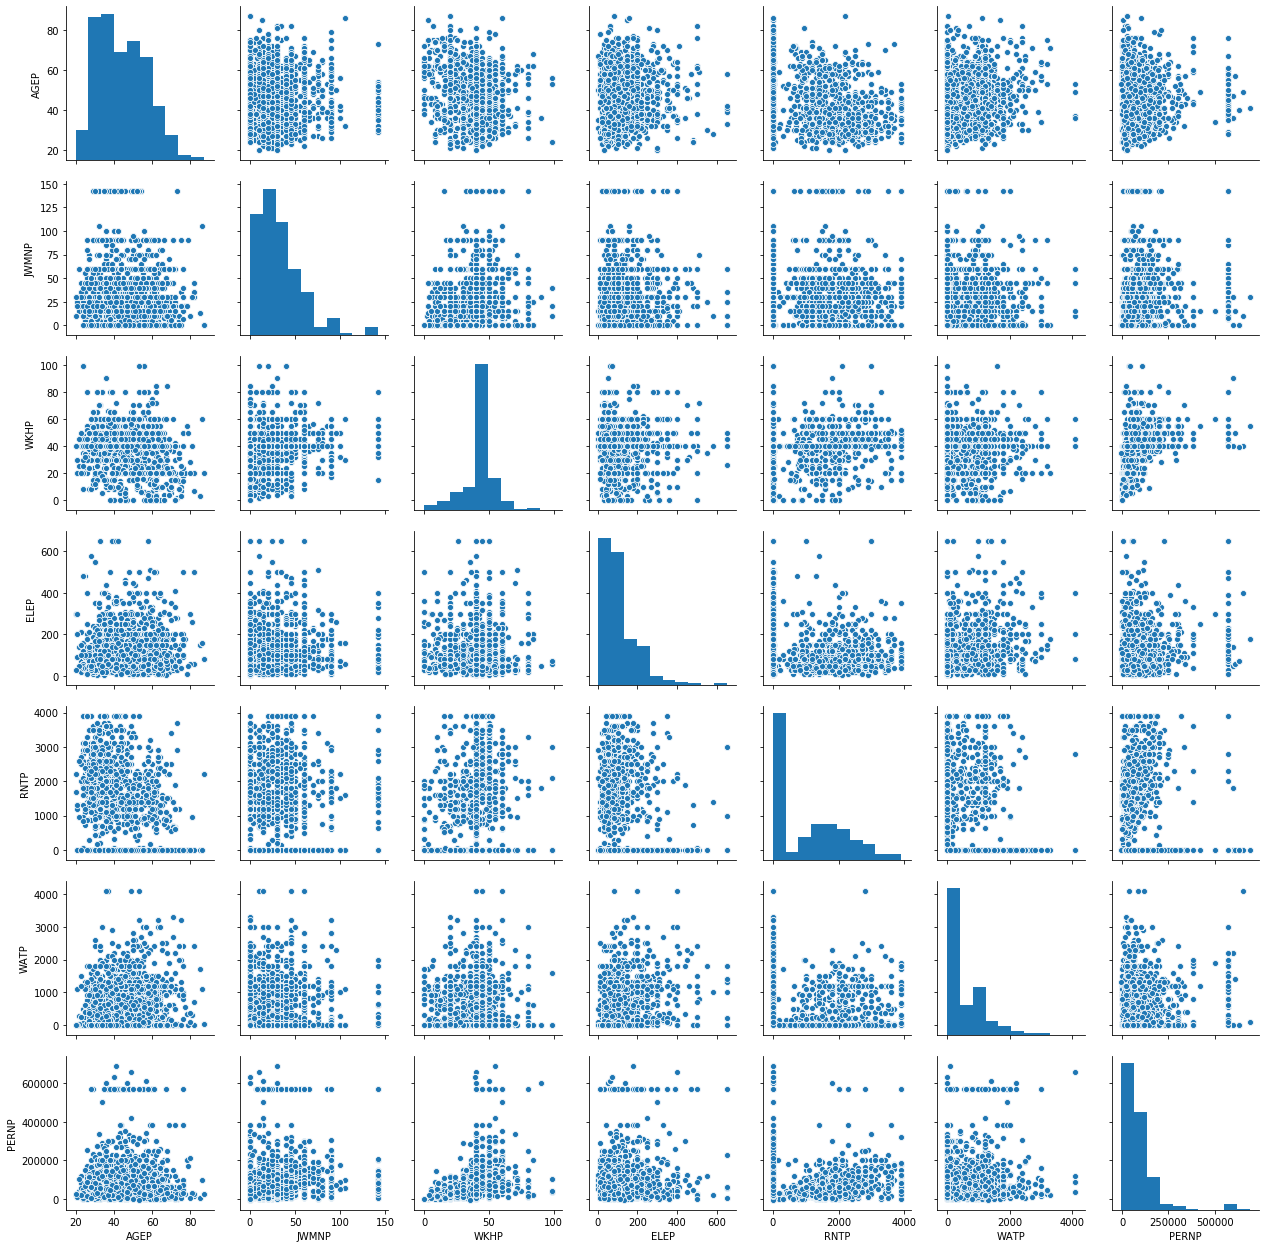

In [549]:
sn.pairplot(numerical.sample(10000))

None of my predictors appear to be correlated with each other.

#### Categorical Features

In [550]:
cat = df.loc[:,['PUMA', 'ESR', 'FER', 'MIL', 'SEX', 'DIS', 'HICOV', 'ACCESS']]

### Preprocessing

#### Scale numerical

In [551]:
scaler = MinMaxScaler()

In [552]:
scaledNum = pd.DataFrame(scaler.fit_transform(numerical), columns=['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP'])

In [553]:
scaledNum.head()

,AGEP,JWMNP,WKHP,ELEP,RNTP,WATP,PERNP
0,0.283582,0.316901,0.40404,0.133127,0.0,0.390244,0.26591
1,0.283582,0.316901,0.40404,0.133127,0.0,0.390244,0.26591
2,0.283582,0.316901,0.40404,0.133127,0.0,0.390244,0.26591
3,0.283582,0.316901,0.40404,0.133127,0.0,0.390244,0.26591
4,0.283582,0.316901,0.40404,0.133127,0.0,0.390244,0.26591


In [554]:
scaledNum.shape

(161988, 7)

#### encode categorical

Label encode binary features

In [555]:
le = LabelEncoder()
le.fit(cat.PUMA)
le.classes_
cat.PUMA = le.transform(cat.PUMA)

In [556]:
le = LabelEncoder()
le.fit(cat.SEX)
le.classes_
cat.SEX = le.transform(cat.SEX)

In [557]:
le = LabelEncoder()
le.fit(cat.FER)
le.classes_
cat.FER = le.transform(cat.FER)

In [558]:
le = LabelEncoder()
le.fit(cat.DIS)
le.classes_
cat.DIS = le.transform(cat.DIS)

In [559]:
le = LabelEncoder()
le.fit(cat.HICOV)
le.classes_
cat.HICOV = le.transform(cat.HICOV)

In [560]:
le = LabelEncoder()
le.fit(cat.ACCESS)
le.classes_
cat.ACCESS = le.transform(cat.ACCESS)

One hot encode nominal features

In [561]:
#ohe = OneHotEncoder()
#ohe.fit(cat.ESR)
#ohe.transform(cat.ESR).toarray()

In [562]:
cat = cat.drop(columns=['PUMA', 'ESR', 'MIL']).copy()

In [563]:
cat.head()

,FER,SEX,DIS,HICOV,ACCESS
6848,1,1,1,0,0
6849,1,1,1,0,0
6850,1,1,1,0,0
6851,1,1,1,0,0
6852,1,1,1,0,0


In [564]:
cat.shape

(161988, 5)

Join datasets

In [565]:
cat[['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']] = scaledNum

#### training test split

In [566]:
['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']

['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']

In [576]:
X = scaledNum
Y = df.loc[:, ["ASSISTANCE"]]

In [577]:
X.shape

(161988, 7)

In [578]:
Y.shape

(161988, 1)

In [579]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.40, shuffle = True)

In [580]:
X_train.head()

,AGEP,JWMNP,WKHP,ELEP,RNTP,WATP,PERNP
96520,0.373134,0.211268,0.505051,0.133127,0.000000,0.341463,0.168223
146527,0.597015,0.070423,0.404040,0.102167,0.000000,0.000000,0.041804
109637,0.567164,0.000000,0.404040,0.195046,0.000000,0.243902,0.050280
144785,0.567164,0.211268,0.444444,0.241486,0.000000,0.219512,0.179716
95786,0.552239,0.000000,0.000000,0.117647,0.512821,0.365854,0.007327


In [585]:
y_train.ASSISTANCE.value_counts()

0.0    89755
1.0     7437
Name: ASSISTANCE, dtype: int64

In [571]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [572]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\lalin90\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\lalin90\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [573]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


In [574]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[59838     0]
 [ 4958     0]]
